In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", rc={'xtick.bottom': True, 'ytick.left': True})
%config InlineBackend.figure_format = 'retina'

# Self-compiled country data

In [2]:
pop_df = pd.read_csv("data/country-data/population.csv")
pop_df = pop_df.set_index("Country")
pop_df.head()

,Population,Date,Source
Country,,,
Mainland China,1401884960,23 Mar 2020,National population clock
India,1360134418,23 Mar 2020,National population clock
US,329499412,23 Mar 2020,National population clock
Indonesia,266911900,1 Jul 2019,National annual projection
Pakistan,219038520,23 Mar 2020,2017 census


In [3]:
hospital_df = pd.read_csv("data/country-data/hospital-capacity.csv")
hospital_df = hospital_df.set_index("Country")
hospital_df = hospital_df.rename(columns={"ICU-CCB beds per 100000 inhabitants": "icuP1e5"})
hospital_df.head()

,Continent,2013,2014,2015,2016,2017,icuP1e5,Ventilators
Country,,,,,,,,
Japan,Asia,13.30,13.21,13.17,13.11,13.05,7.3,Unknown
South Korea,Asia,10.92,11.59,11.61,11.98,12.27,10.6,Unknown
Russia,Europe,9.07,8.81,8.35,8.16,8.05,8.3,Unknown
Germany,Europe,8.28,8.23,8.13,8.06,8.00,29.2,25000
Austria,Europe,7.64,7.58,7.54,7.42,7.37,21.8,Unknown


# CSSE data

In [4]:
case_df = pd.read_csv(
    "data/csse-github/data/cases_time.csv"
).rename(columns={
    "Country_Region": "Country",
    "Last_Update": "Date",
}).drop(columns=[
    "Delta_Confirmed",
    "Delta_Recovered"
]).replace({
    "United Kingdom": "UK",
    "Korea, South": "South Korea"
})

case_df.Date = pd.to_datetime(case_df.Date)
case_df.head()

,Country,Date,Confirmed,Deaths,Recovered,Active
0,Afghanistan,2020-01-22,0,0,NaN,NaN
1,Afghanistan,2020-01-23,0,0,NaN,NaN
2,Afghanistan,2020-01-24,0,0,NaN,NaN
3,Afghanistan,2020-01-25,0,0,NaN,NaN
4,Afghanistan,2020-01-26,0,0,NaN,NaN


# Cases vs. Time

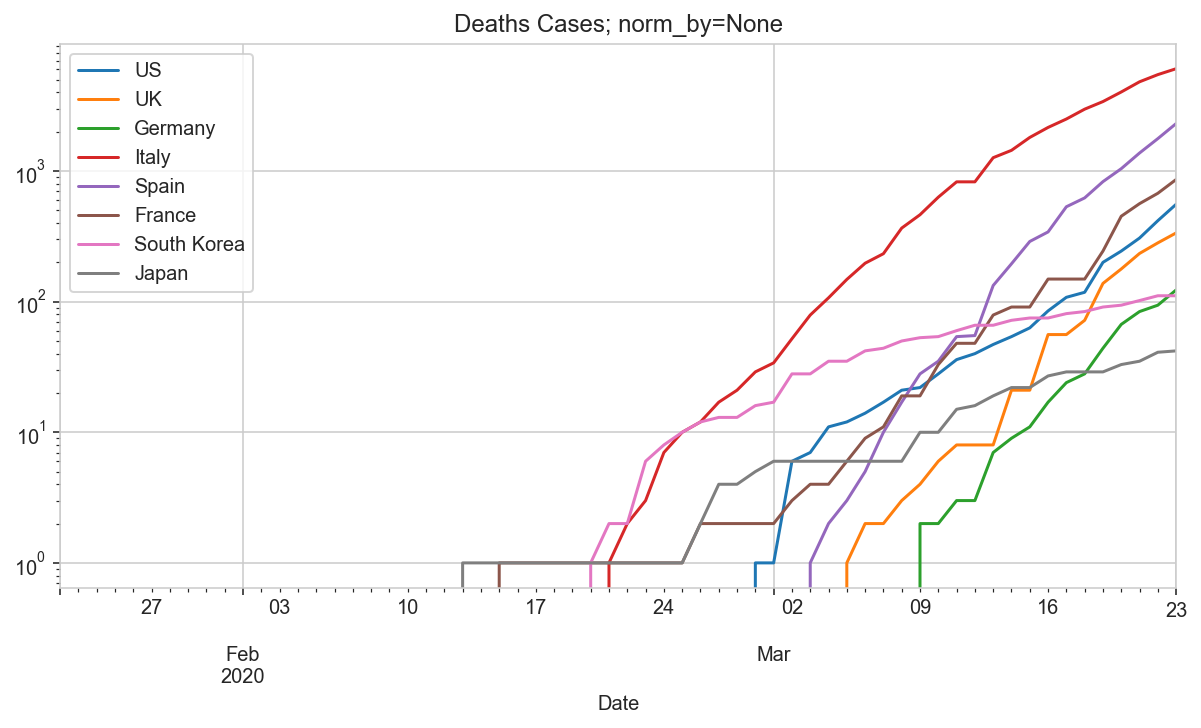

In [5]:
def plot_cases(ax, countries, col, norm_by):    
    for country in countries:
        xs = case_df[case_df.Country == country].set_index("Date")[col]
        if norm_by == "pop":
            xs /= pop_df.loc[country].Population
        elif norm_by == "icu":
            xs /= hospital_df.loc[country].icuP1e5 * pop_df.loc[country].Population / 1e5
        elif norm_by == "bed":
            beds = hospital_df.loc[country]["2017"]
            if np.isnan(beds):
                beds = hospital_df.loc[country]["2016"]
            xs /= beds * pop_df.loc[country].Population / 1e3
        xs.plot.line(logy=True, label=country, ax=ax)
    ax.legend()

fig, ax = plt.subplots(figsize=(10, 5))
COUNTRIES = [
    "US",
    "UK",
    "Germany",
    "Italy",
    "Spain",
    "France",
    "South Korea",
    "Japan",
]
COL = "Deaths"
NORM_BY = None
plot_cases(
    ax=ax,
    countries=COUNTRIES,
    col=COL,
    norm_by=NORM_BY
)
plt.title(f"{COL} Cases; norm_by={NORM_BY}");

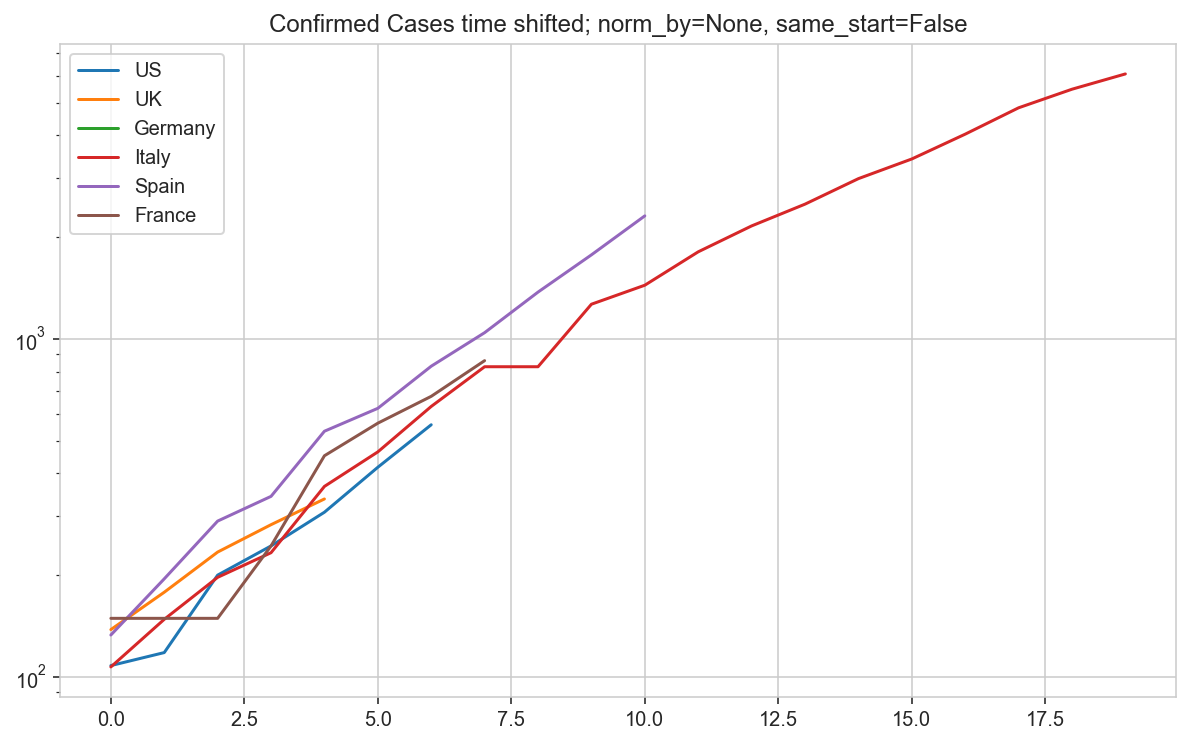

In [6]:
def plot_cases_shifted(ax, countries, col, norm_by, start_val, same_start=False):    
    for country in countries:
        xs = case_df[case_df.Country == country].set_index("Date")[col]
        if norm_by == "pop":
            xs /= pop_df.loc[country].Population
        elif norm_by == "icu":
            xs /= hospital_df.loc[country].icuP1e5 * pop_df.loc[country].Population / 1e5
        elif norm_by == "bed":
            beds = hospital_df.loc[country]["2017"]
            if np.isnan(beds):
                beds = hospital_df.loc[country]["2016"]
            xs /= beds * pop_df.loc[country].Population / 1e3
        xs = xs[xs >= start_val].reset_index()
        
        if same_start:
            xs /= xs.loc[0]
            xs *= start_val
        xs.plot.line(y=col, logy=True, label=country, ax=ax)
    
fig, ax = plt.subplots(figsize=(10, 6))
COUNTRIES = [
    "US",
    "UK",
    "Germany",
    "Italy",
    "Spain",
    "France",
    #"South Korea",
    #"Japan"
]
COL = "Deaths"
NORM_BY = None
START_VAL = 100
SAME_START = False
plot_cases_shifted(
    ax=ax,
    countries=COUNTRIES,
    col=COL,
    norm_by=NORM_BY,
    start_val=START_VAL,
    same_start=SAME_START
)
plt.title(f"Confirmed Cases time shifted; norm_by={NORM_BY}, same_start={SAME_START}");

# Growth Rates

In [7]:
def get_growth_rate(country, col, n_days, n_sigma=2):
    data = case_df[col][case_df.Country == country]
    ys = np.log(data.to_numpy()[-n_days:])
    xs = sm.add_constant(np.arange(len(ys)))
    
    ols = sm.OLS(ys, xs)
    ols_result = ols.fit()
    
    log_rate = ols_result.params[1]
    se = ols_result.HC3_se[1] # https://jslsoc.sitehost.iu.edu/files_research/testing_tests/hccm/00TAS.pdf
    
    rate = np.exp(log_rate) - 1
    lo_err = rate - (np.exp(log_rate - n_sigma * se) - 1)
    hi_err = np.exp(log_rate + n_sigma * se) - 1 - rate
    return rate, lo_err, hi_err

print(get_growth_rate("US", col="Confirmed", n_days=7))
print(get_growth_rate("US", col="Deaths", n_days=7))

(0.3935397097947493, 0.05668336948219599, 0.059086772360252615)
(0.3247675183815033, 0.04700669269440105, 0.04873599063001244)


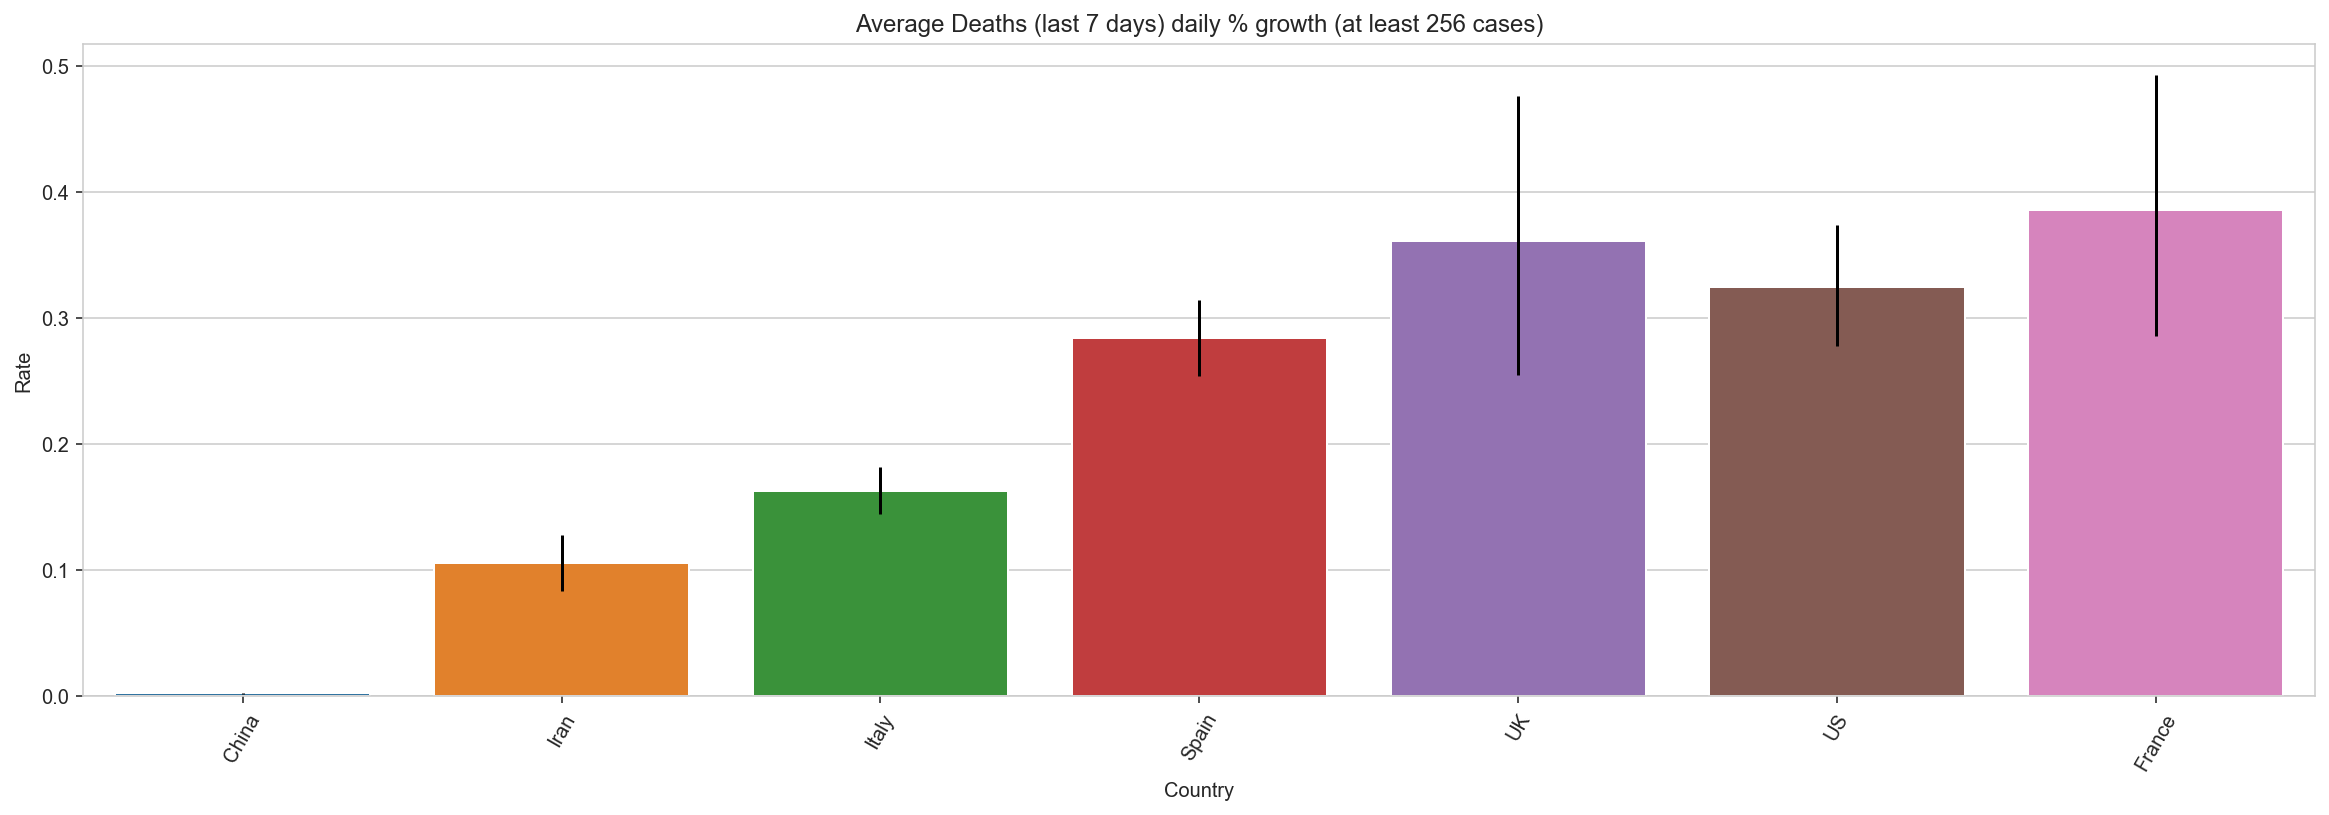

In [9]:
def get_growth_rate_by_country(n_days, col, min_cases, n_sigma):
    ret = {}
    for country in case_df.Country.unique():
        if case_df[col][case_df.Country == country].max() < min_cases:
            continue
        rate, lo_err, hi_err = get_growth_rate(country, col, n_days, n_sigma)
        if not np.isnan(lo_err) and not np.isnan(hi_err):
            ret[country] = [rate, lo_err, hi_err]

    return (
        pd.DataFrame.from_dict(ret, orient="index", columns=['Rate', "LoErr", "HiErr"])
        .reset_index()
        .rename(columns={"index": "Country"})
    )

plt.figure(figsize=(20,6))
plt.xticks(rotation=60)
COL = "Deaths"
MIN_CASES=256
N_DAYS=7
N_SIGMA=2
plt.title(f"Average {COL} (last {N_DAYS} days) daily % growth (at least {MIN_CASES} cases)")
data = get_growth_rate_by_country(
    n_days=N_DAYS,
    col=COL,
    min_cases=MIN_CASES,
    n_sigma=N_SIGMA
)
data["LoRate"] = data.Rate - data.LoErr
data = data.sort_values(by="LoRate")
sns.barplot(
    data=data,
    x="Country",
    y="Rate",
    yerr=np.array([data.LoErr.to_numpy(), data.HiErr.to_numpy()])
);